In [26]:
import warnings
warnings.filterwarnings('ignore')
# % pip install pandas
# % pip install matplotlib
# % pip install numpy
# %pip install instaloader
import instaloader
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import numpy as np

import reelscraper as rs

# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("fast")


from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':11})

# # Set the font used for MathJax - more on this later
# rc('mathtext',**{'default':'regular'})

In [2]:
# Creating an instance of the Instaloader class
bot = instaloader.Instaloader()
# bot.login(user="Your_username",passwd="Your_password") ## Use this to log-in to your account
# NOTE signing in will probably get your account terminated/banned on instagram, so it is safest to use instaloader anonymously

### Creating SQLite database and tables

In [2]:
# create and connect to database
conn = sqlite3.connect("instagram_artists_apresearch.db")
cursor = conn.cursor()

cmd = ""

We will have 2 tables, one for the profiles and one for the posts.
Both tables will contain both human and ai content, with a column identifying which they are

In [ ]:
# create table of all profiles
# column is_human is true if profile is a human artist
cmd = """CREATE TABLE PROFILES(
    user_id INT,
    username VARCHAR(30),
    num_followers INT,
    num_posts INT,
    is_human BOOLEAN,
    PRIMARY KEY (user_id)
    );"""
cursor.execute(cmd)

# create table of all posts
cmd = """CREATE TABLE POSTS(
owner_user_id INT,
owner_username VARCHAR(30),
num_likes INT,
num_comments INT,
shortcode VARCHAR(255),
img_url VARCHAR(255),
post_date DATE,
is_reel BOOLEAN,
FOREIGN KEY(owner_user_id) REFERENCES PROFILES(user_id)
);"""
cursor.execute(cmd)

### Adding data into our sql database and tables

We will create our tables using .csv files. Files must formatted so the first row are column names and thefirst column will not contain information.

#### NOTE Only values outside of the first row and column will be added into the table

In [ ]:
def add_to_tables(csv_path, is_human_val):
    # is_human_val is whether the csv contains human or ai artist profiles

    conn = sqlite3.connect("instagram_artists_apresearch.db")
    cursor = conn.cursor()

    df = pd.read_csv(csv_path)

    start_profile = "" # empty if starting at beginning of csv else set it to what profile you need to start adding
    after_post = "" # empty if starting at beginning of profile or csv else set it to what post you want to start adding after
    past_post = len(after_post) == 0 # False if you need to only add posts after a specific post within a profile (will continue adding profiles after)
    # if past_post is False, past_profile must be False
    past_profile = past_post and (len(start_profile) == 0) # False if you need to only add profiles starting at a specific profile or post


    for i in df.index:
        for col in df.columns[1:]:
            curr_post = None
            curr_profile = None
            try:
                if(pd.notna(df.loc[i,col])):
                    curr_profile = df.loc[i,col]
                    print(curr_profile)
                    ## used to start adding profiles at a profile or post (profile inclusive, post exclusive)
                    if(curr_profile == start_profile):
                        past_profile = True
                    
                    if(past_profile):
                        p = instaloader.Profile.from_username(bot.context, df.loc[i,col]) # grab profile from instagram
                        print(f"{p.userid}, {p.username}, {p.followers}, {p.mediacount}, {is_human_val}, {df.iloc[i,0]}") # track current profile

                        # check if profile does not already exist in table
                        cursor.execute("SELECT 1 FROM PROFILES WHERE USER_ID = {}".format(p.userid))
                        existing_row = cursor.fetchone()

                        if not existing_row:
                            # insert the row
                            cmd= """INSERT INTO PROFILES(USER_ID, USERNAME, NUM_FOLLOWERS, NUM_POSTS, IS_HUMAN, GENRE) 
                                    VALUES ({}, "{}", {}, {}, {}, "{}");""".format(
                                        p.userid, p.username, p.followers, p.mediacount, is_human_val, df.iloc[i,0]
                                    )
                            cursor.execute(cmd)
                        
                        # add all posts from profile's main feed
                        # this includes reels, but we will edit this later
                        for post in p.get_posts():
                            if(past_post):
                                curr_post = post.shortcode + " on main" # keep track of current post which was added
                                cmd= """INSERT INTO POSTS(OWNER_USER_ID, OWNER_USERNAME, NUM_LIKES, NUM_COMMENTS, SHORTCODE, POST_DATE, IS_REEL, IS_HUMAN) 
                                        VALUES ({}, "{}", {}, {}, "{}", "{}", {}, {});""".format(
                                            post.owner_id, post.owner_username, post.likes, post.comments, post.shortcode, post.date_utc, False, is_human_val
                                        ) # is_reel column is set to False regardless if it is a reel or not
                                cursor.execute(cmd)
                            ## used to start adding after a specific post (post exclusive). this post should already be included in the table
                            ## uses post shortcode as identifier
                            # if (post.shortcode == after_post):
                            #     past_post = True
                        
                        # add all reels from a profile's reel tab
                        for reel in rs.from_user_get_reels(df.loc[i,col]):
                            if(past_post):
                                # check if reel was already added via main feed
                                cmd= """SELECT EXISTS(SELECT 1 FROM POSTS WHERE shortcode = "{}")""".format(reel)
                                cursor.execute(cmd)
                                exists = cursor.fetchone()[0]

                                if(exists):
                                    # if it was already added, set the is_reel value to True
                                    cmd= """UPDATE POSTS
                                            SET IS_REEL = TRUE
                                            WHERE shortcode = '{}'""".format(reel)
                                else:
                                    # grab reel data from instagram
                                    post = instaloader.Post.from_shortcode(bot.context, reel)
                                    cmd= """INSERT OR IGNORE INTO POSTS(OWNER_USER_ID, OWNER_USERNAME, NUM_LIKES, NUM_COMMENTS, SHORTCODE, POST_DATE, IS_REEL, IS_HUMAN) 
                                            VALUES ({}, "{}", {}, {}, "{}", "{}", {}, {});""".format(
                                                post.owner_id, post.owner_username, post.likes, post.comments, post.shortcode, post.date_utc, True, is_human_val
                                            ) # is_reel value is True
                                cursor.execute(cmd)
                                curr_post = reel + " on reels"
                            # if (reel == after_post):
                            #     past_post = True
                        conn.commit() # commit data after every profile
                                
            # exception handling mainly for profiles not found, faulty networks connections, or instagram blocking us temporarily
            # this helps keep track of and continue where we left off, which is why we have the past_profile and past_post
            except Exception as e:
                conn.commit()
                conn.close()
                print(f"Error with {df.loc[i,col]}, after {curr_post} : {e}")
                return
    # IMPORTANT finally save all changes to database, changes are not committed every insert
    # conn.commit()
    conn.close()

In [ ]:
add_to_tables("HA.csv", True) # add human profiles and posts into tables

In [ ]:
add_to_tables("AIA.csv", False) # add AI profiles and posts into tables

In [ ]:
# cmd= """SELECT POSTS.*
#         FROM POSTS
#         JOIN PROFILES ON POSTS.owner_user_id = PROFILES.user_id
#         WHERE PROFILES.num_followers > 50000;
#         """
# posts_df = pd.read_sql(cmd, conn)
# posts_df['post_date'] = pd.to_datetime(posts_df['post_date'])

In [3]:
cmd= """SELECT POSTS.*
        FROM POSTS
        """
posts_df = pd.read_sql(cmd, conn)
posts_df['post_date'] = pd.to_datetime(posts_df['post_date'])

In [4]:
cmd= """SELECT PROFILES.*
        FROM PROFILES
        """
profiles_df = pd.read_sql(cmd, conn)

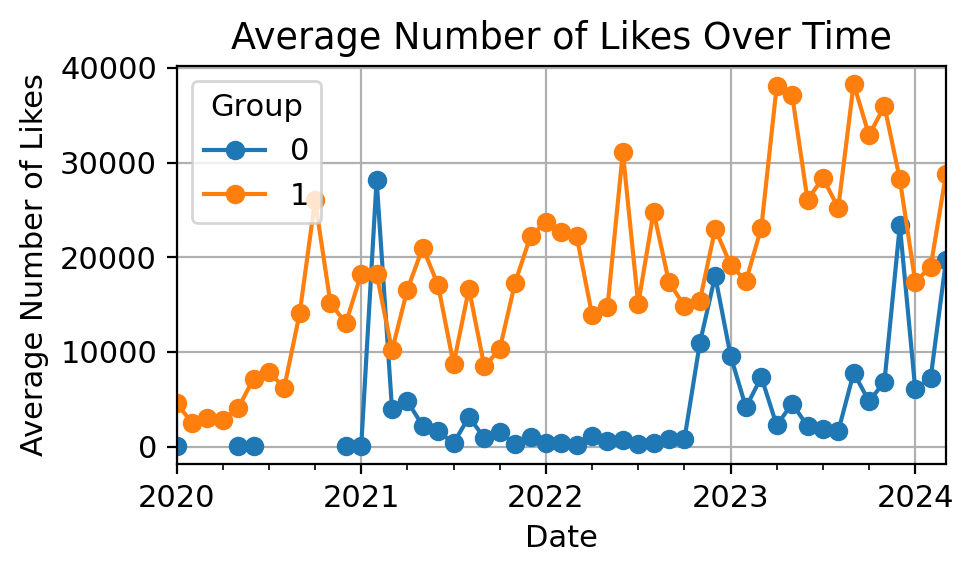

In [5]:
filtered_df = posts_df[(posts_df['num_likes'] >= 0) & (posts_df['is_reel'] == 1) & (posts_df['post_date'] >= "2020-01-01")]

date_freq = "M"
# Calculate average likes per group and date
avg_likes = filtered_df.groupby(['is_human', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].mean().reset_index()
# avg_likes = filtered_df.groupby(["owner_username", pd.Grouper(key='owner_username')])['num_likes'].mean().reset_index()

# Pivot the data for easier plotting
pivot_df = avg_likes.pivot(index='post_date', columns='is_human', values='num_likes')

# Plotting
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

<Axes: >

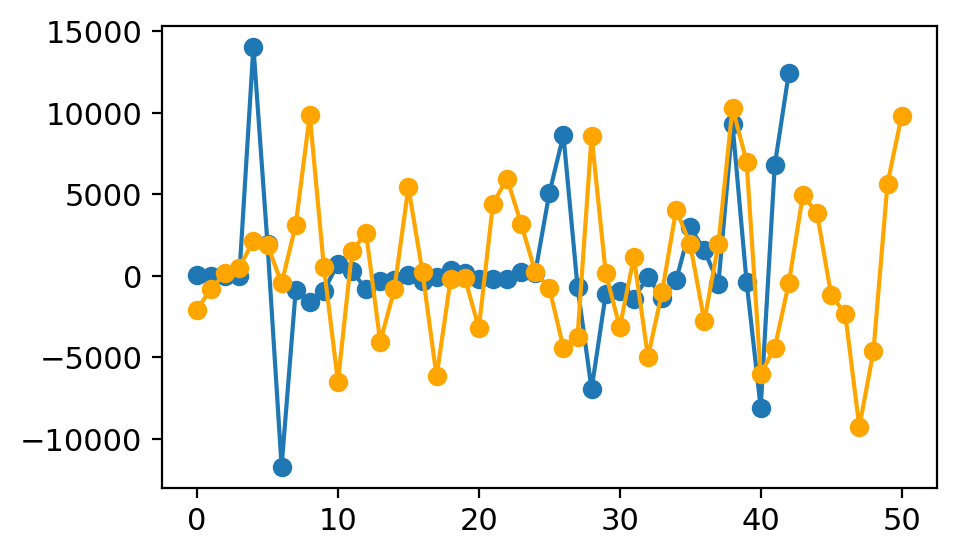

In [6]:
f = avg_likes[avg_likes["is_human"] == 0].reset_index()
dfdx = np.gradient(f["num_likes"], f.index)
# dfdx
pd.Series(dfdx).plot(kind='line', marker='o', figsize=(5, 3))

f2 = avg_likes[avg_likes["is_human"] == 1].reset_index()
df2dx = np.gradient(f2["num_likes"], f2.index)
# dfdx
pd.Series(df2dx).plot(kind='line', marker='o', figsize=(5, 3), color='orange')

In [7]:
pd.Series(df2dx).corr(pd.Series(dfdx))

0.01651649218581923

['alpha2']

                    Breakpoint Regression Results                     
No. Observations                      120
No. Model Parameters                    4
Degrees of Freedom                    116
Res. Sum of Squares           6.25458e+06
Total Sum of Squares          6.92832e+07
R Squared                        0.909725
Adjusted R Squared               0.906585
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                20.2102         50.2      0.40242         0.688      -79.261       119.68
alpha1              0.441662         1.04      0.42269         0.673      -1.6279       2.5112
beta1                71.0661         3.87       18.367             -       63.403       78.729
breakpoint1           83.459          1.3            -             -       80.878        86.04
------

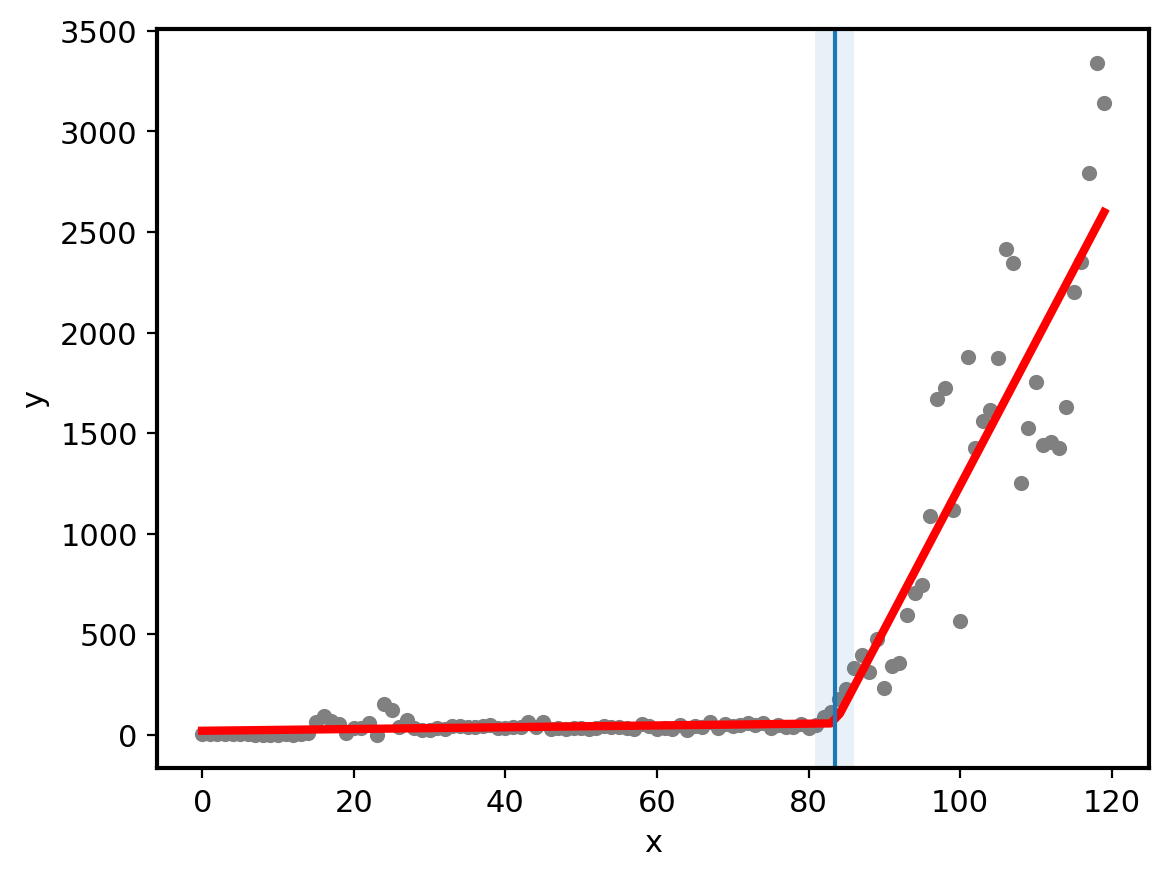

In [28]:
#%pip install piecewise-regression
import piecewise_regression
pw_fit = piecewise_regression.Fit(np.array(f.index), np.array(f['ER']), n_breakpoints=1)
pw_fit.summary()
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=3)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

Algorithm did not converge. Try different n_breakpoints, different start_values, or start_values=None
Summary of why the algorithm did not converge:
Run 1: Breakpoint values outside range 
Run 2: Breakpoint values outside range 
Run 3: Breakpoint values outside range 
Run 4: Breakpoint values outside range 
Run 5: Breakpoint values outside range 
Run 6: Breakpoint values outside range 
Run 7: Breakpoint values outside range 
Run 8: Breakpoint values outside range 
Run 9: Breakpoint values outside range 
Run 10: Breakpoint values outside range 
Run 11: Breakpoint values outside range 
Run 12: Breakpoint values outside range 
Run 13: Breakpoint values outside range 
Run 14: Breakpoint values outside range 
Run 15: Breakpoint values outside range 
Run 16: Breakpoint values outside range 
Run 17: Breakpoint values outside range 
Run 18: Breakpoint values outside range 
Run 19: Breakpoint values outside range 
Run 20: Breakpoint values outside range 
Run 21: Breakpoint values outside range 

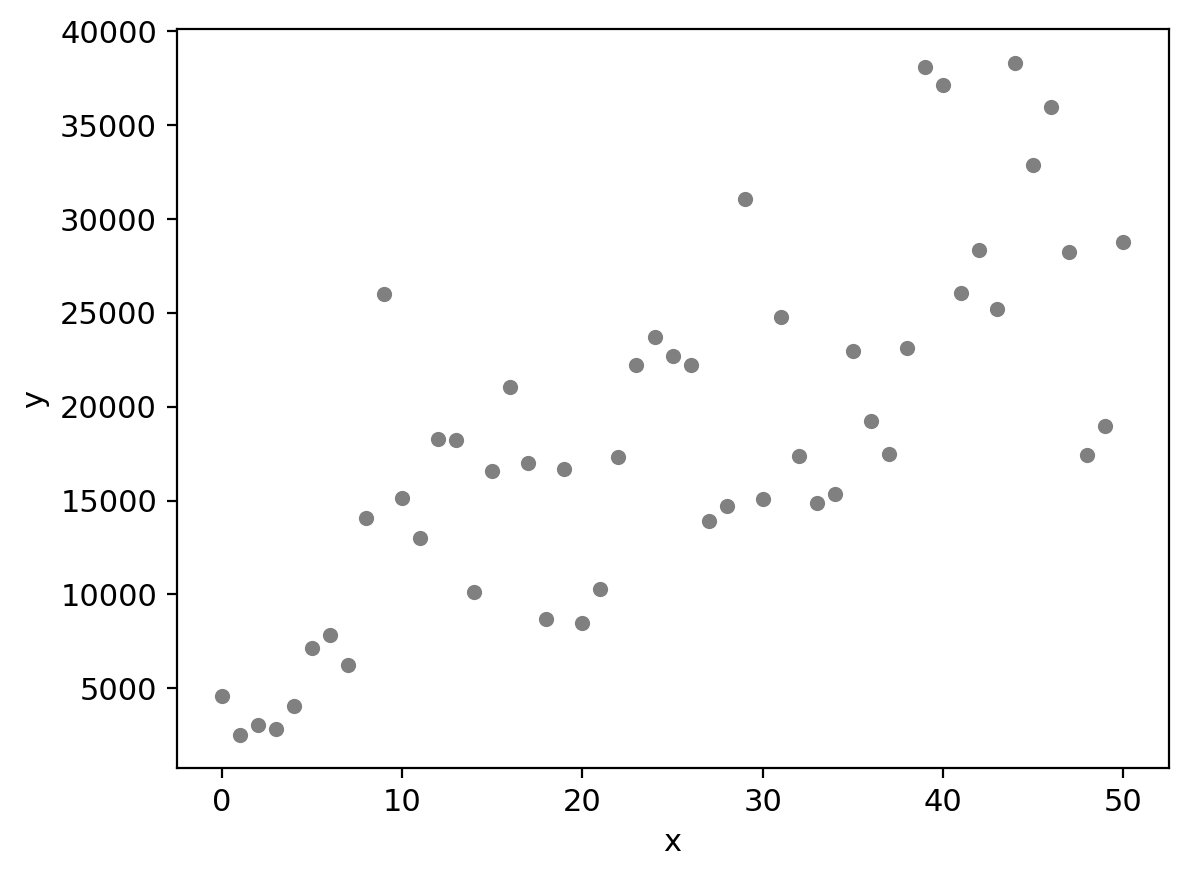

In [8]:
#%pip install piecewise-regression
pw_fit = piecewise_regression.Fit(np.array(f2.index), np.array(f2['num_likes']), n_breakpoints=1)
pw_fit.summary()
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=3)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

In [9]:
plt.rcParams['axes.linewidth'] = 1.5
plt.rc('axes',edgecolor='black')

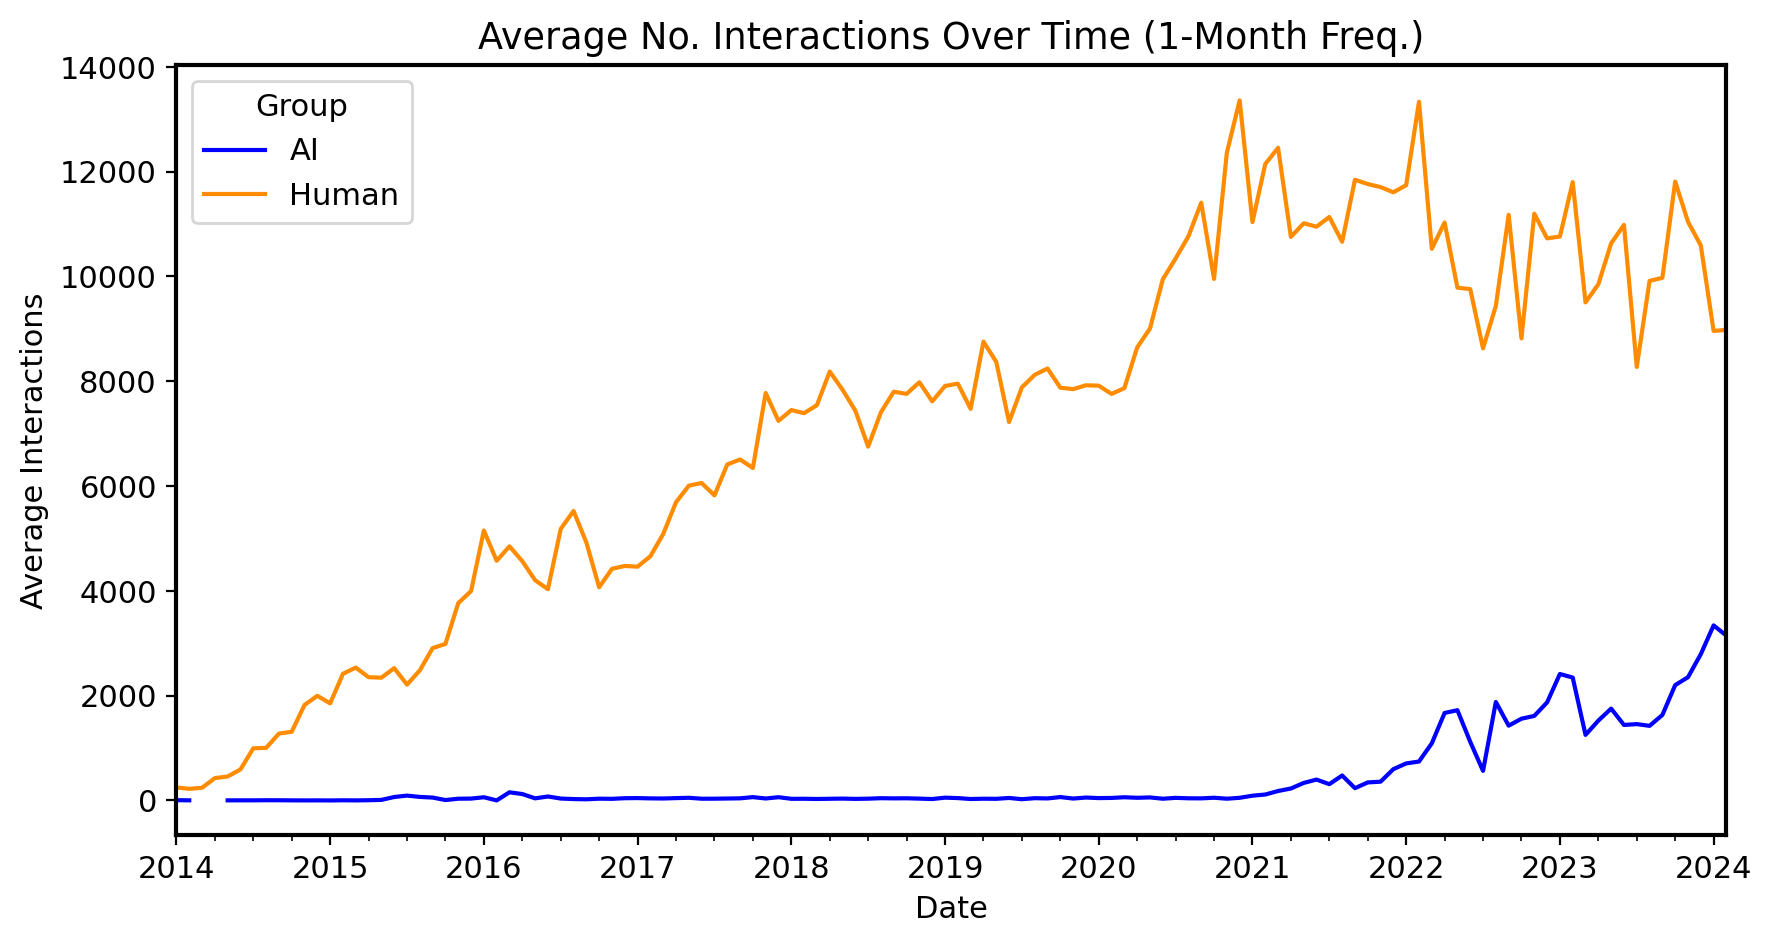

In [15]:
import matplotlib.dates as mdates

filtered_df = posts_df[(posts_df['num_likes'] >= 0) & (posts_df['is_reel'] == 0) & (posts_df['post_date'] >= "2014-01-01")]
merged_dfe= pd.merge(filtered_df, profiles_df, left_on='owner_username', right_on='username')
# ai_mdf = merged_df[merged_df["is_human_x"] == 0]
# h_mdf = merged_df[merged_df["is_human_x"] == 1]
merged_dfe["ER"] = (merged_dfe["num_likes"] + merged_dfe["num_comments"])# / merged_dfe['num_followers']
# Calculate average likes per group and date
avg_likes = merged_dfe.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)])['ER'].mean().reset_index()

# avg_likes = filtered_df.groupby(["owner_username", pd.Grouper(key='owner_username')])['num_likes'].mean().reset_index()

# Pivot the data for easier plotting
pivot_df = avg_likes.pivot(index='post_date', columns='is_human_x', values='ER')

# Plotting
pivot_df.plot(kind='line', figsize=(10, 5), color= ['blue', 'darkorange'])
plt.title('Average No. Interactions Over Time (1-Month Freq.)')
plt.xlabel('Date')
plt.ylabel('Average Interactions')
plt.grid(False)
plt.legend(title='Group', labels= ["AI", "Human"])
# plt.axis.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

# # Rotates and right-aligns the x labels so they don't crowd each other.
# for label in plt.get_xticklabels(which='major'):
#     label.set(rotation=30, horizontalalignment='right')
# plt.tight_layout()
plt.show()

0


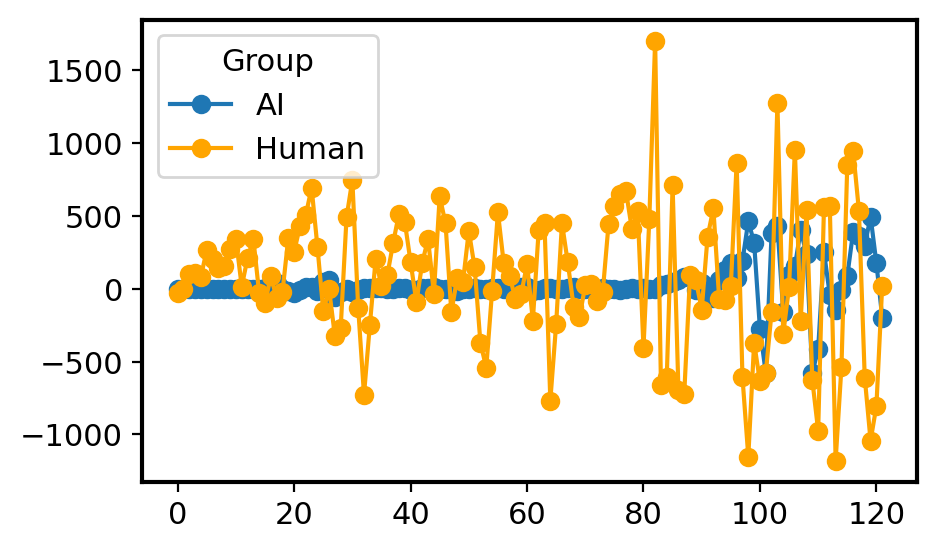

In [16]:
f = avg_likes[avg_likes["is_human_x"] == 0].reset_index()
dfdx = np.gradient(f["ER"], f.index)

f2 = avg_likes[avg_likes["is_human_x"] == 1].reset_index()
df2dx = np.gradient(f2["ER"], f2.index)
# print(len(f2) - len(f))

dfdx = np.pad(dfdx, (len(f2) - len(f),0))
# dfdx2
print(len(dfdx) - len(df2dx))
pd.Series(dfdx).plot(kind='line', marker='o', figsize=(5, 3))
pd.Series(df2dx).plot(kind='line', marker='o', figsize=(5, 3), color='orange')
plt.grid(False)
plt.legend(title='Group', labels= ["AI", "Human"])

In [17]:
pd.Series(df2dx).corr(pd.Series(dfdx))

0.11330232167522006

In [34]:
#%pip install piecewise-regression
import piecewise_regression
pw_fit = piecewise_regression.Fit(np.array(f2.index), np.array(f2['ER']), n_breakpoints=1)
pw_fit.summary()
pass

['alpha2']

                    Breakpoint Regression Results                     
No. Observations                      122
No. Model Parameters                    4
Degrees of Freedom                    118
Res. Sum of Squares           9.05233e+07
Total Sum of Squares          1.48754e+09
R Squared                        0.939146
Adjusted R Squared               0.937065
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                589.966     1.85e+02       3.1863       0.00184       223.31       956.62
alpha1               123.195         3.68       33.517      3.87e-62       115.92       130.47
beta1               -171.711         15.7      -10.905             -      -202.89      -140.53
breakpoint1          87.7452         2.05            -             -       83.692       91.799
------

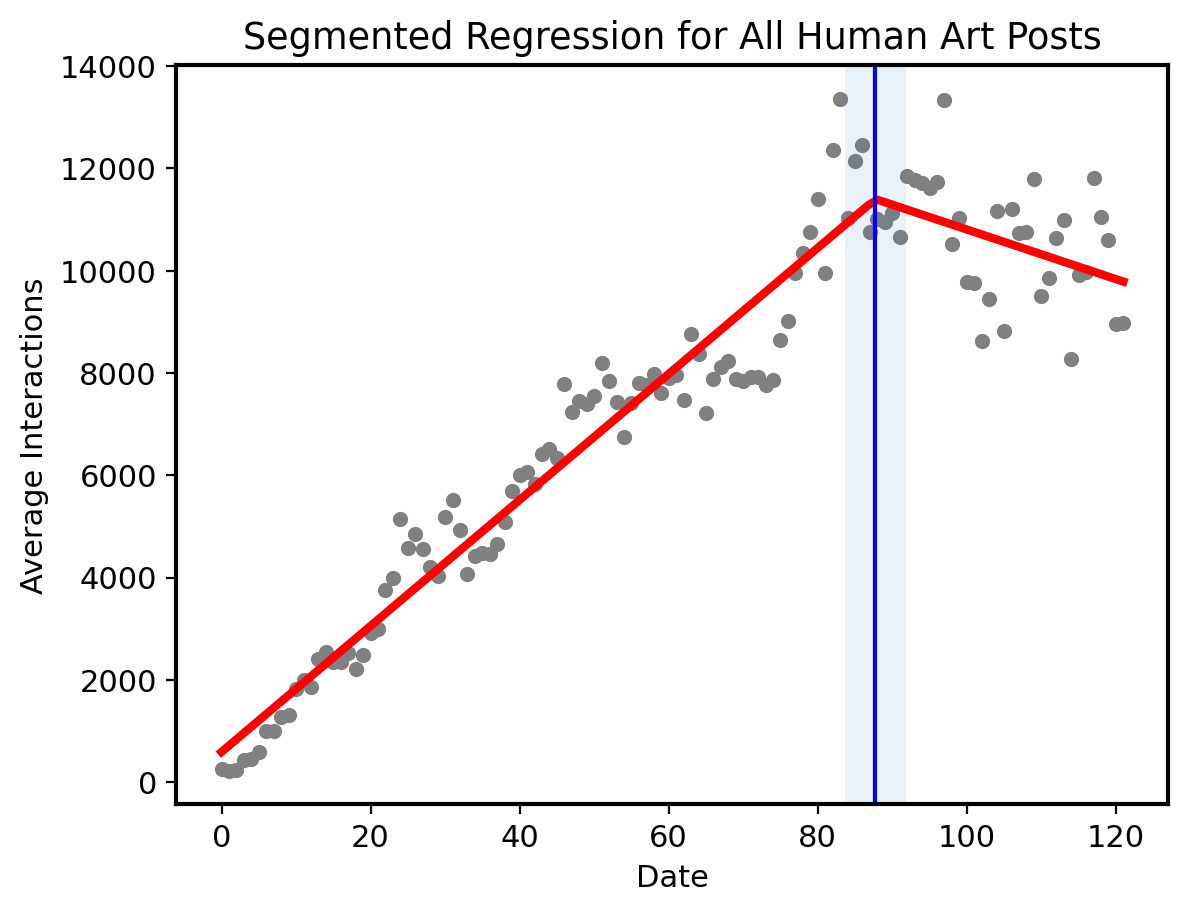

In [40]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=3)
pw_fit.plot_breakpoints(color= 'blue')
pw_fit.plot_breakpoint_confidence_intervals()
plt.title("Segmented Regression for All Human Art Posts")
plt.ylabel("Average Interactions")
plt.xlabel("Date")
plt.xticks(np.arange(0,121,20) + pd.Timestamp('2014-1-1'))
plt.show()
plt.close()

In [34]:
pw_fit = piecewise_regression.Fit(np.array(f.index), np.array(f['ER']), n_breakpoints=1)
pw_fit.summary()
pass

['alpha2']

                    Breakpoint Regression Results                     
No. Observations                      120
No. Model Parameters                    4
Degrees of Freedom                    116
Res. Sum of Squares           6.25458e+06
Total Sum of Squares          6.92832e+07
R Squared                        0.909725
Adjusted R Squared               0.906585
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                20.2102         50.2      0.40242         0.688      -79.261       119.68
alpha1              0.441662         1.04      0.42269         0.673      -1.6279       2.5112
beta1                71.0661         3.87       18.367             -       63.403       78.729
breakpoint1           83.459          1.3            -             -       80.878        86.04
------

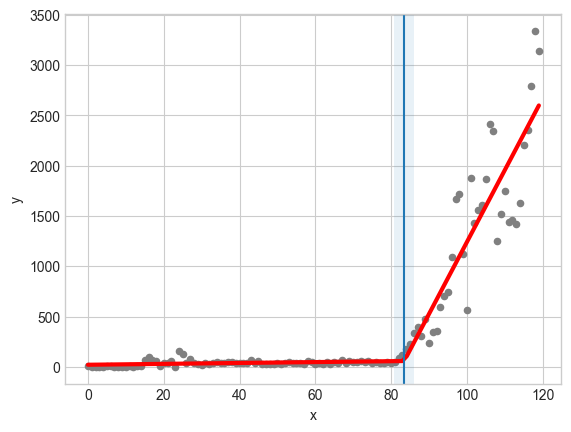

In [35]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=3)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

In [315]:
# Get the key results of the fit
pw_results = pw_fit.get_results()
pw_estimates = pw_results["estimates"]
pw_estimates

{'const': {'estimate': 311.60116378416075,
  'se': 262.8461122349253,
  'confidence_interval': (-240.61802660184281, 863.8203541701644),
  't_stat': 1.1854889582907715,
  'p_t': 0.2512391460330583},
 'beta1': {'estimate': -1117.1274945282757,
  'se': 134.94901072595385,
  'confidence_interval': (-1400.6448454711458, -833.6101435854056),
  't_stat': -8.278145119543481,
  'p_t': '-'},
 'breakpoint1': {'estimate': 15.330024803344852,
  'se': 0.4887864925754873,
  'confidence_interval': (14.303122488120936, 16.356927118568766),
  't_stat': '-',
  'p_t': '-'},
 'alpha1': {'estimate': 732.1180843412037,
  'se': 29.857312005931593,
  'confidence_interval': (669.390199485591, 794.8459691968164),
  't_stat': 24.520562473800645,
  'p_t': 2.7838158404678492e-15},
 'alpha2': {'estimate': -385.00941018707204,
  'se': 131.60462155902448,
  'confidence_interval': (-661.5004602179972, -108.51836015614691),
  't_stat': -2.925500682469543,
  'p_t': 0.00903343188591314}}

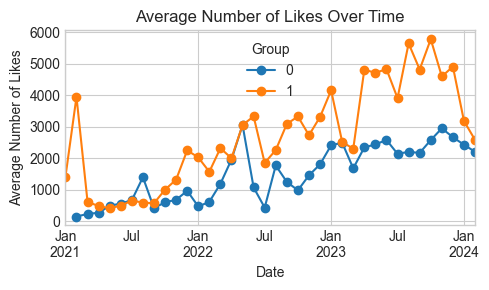

In [36]:
new = pd.DataFrame()
for p in merged_dfe["owner_username"].unique():
   if (merged_dfe[merged_dfe["owner_username"] == p]["post_date"].min()) > pd.to_datetime("2021-1-1")  and (merged_dfe[merged_dfe["owner_username"] == p]["post_date"].min()) < pd.to_datetime("2023-1-1"):
      new = pd.concat([new, merged_dfe[merged_dfe["owner_username"] == p]], ignore_index=True)


# these r the proiles that started after 20203-6-1, plot these out
avg_likes = new.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)])['ER'].mean().reset_index()

# avg_likes = filtered_df.groupby(["owner_username", pd.Grouper(key='owner_username')])['num_likes'].mean().reset_index()
# print(new[new["ER"] > 1][["owner_username", "num_likes", "num_comments", "num_followers", "ER", "is_reel"]])
# print(new[new["is_human_x"] == 1].describe())
# print("------------------------------------------")
# print(new[new["is_human_x"] == 0].describe())
# Pivot the data for easier plotting
pivot_df = avg_likes.pivot(index='post_date', columns='is_human_x', values='ER')

# Plotting
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

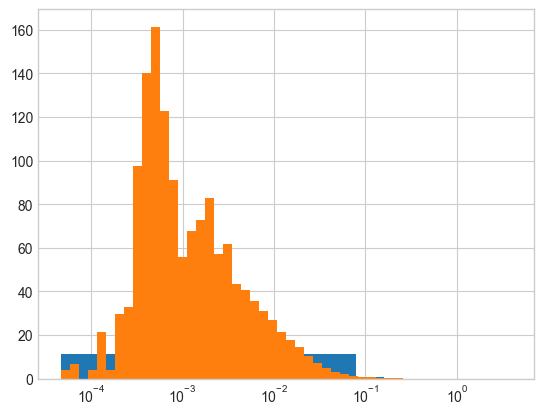

In [51]:
logbins = np.logspace(np.log10(0),np.log10(50))

hist, bins, _ = plt.hist((new[(new["is_human_x"] == 0)]["ER"]), density=True, bins=50)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist((new[(new["is_human_x"] == 0)]["ER"]), density=True, bins=logbins)

plt.xscale('log')
plt.show()

In [307]:
%pip install ruptures

^C
Note: you may need to restart the kernel to use updated packages.


In [153]:
aia = f
haa = f2

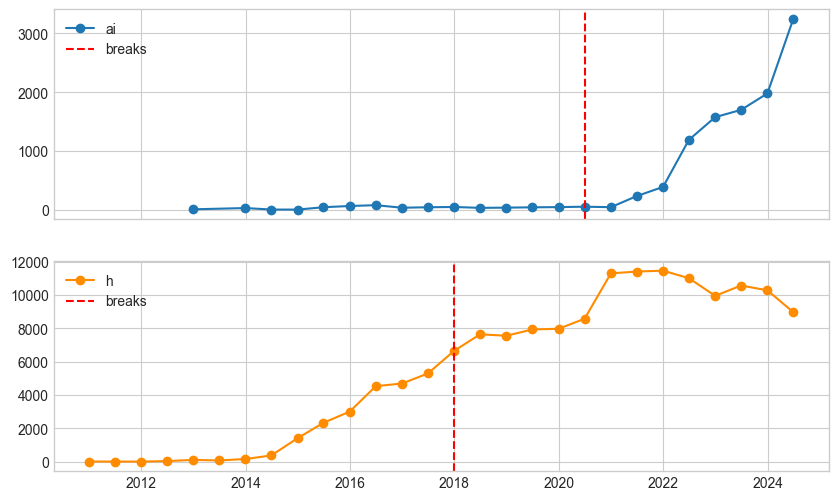

In [155]:
import ruptures as rpt
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))

nbkps = 1
aia.set_index(aia["post_date"], inplace= True)
aits = aia["ER"]

haa.set_index(haa["post_date"], inplace= True)
hts = haa["ER"]

y = np.array(aits.to_list())

model = rpt.Dynp(model= "rbf")
model.fit(y)

breaks = model.predict(n_bkps=nbkps)

breaks_rpt = []
for i in breaks:
    breaks_rpt.append(aits.index[i-1])

breaks_rpt = pd.to_datetime(breaks_rpt)

ax1.plot(aits, marker="o", label='ai')

print_legend = True
for i in breaks_rpt[:-1]:
    if print_legend:
        ax1.axvline(i, color= 'red', linestyle= 'dashed', label= 'breaks')
        print_legend= False
    else:
        ax1.axvline(i, color= 'red', linestyle= 'dashed')

ax1.legend()

y = np.array(hts.to_list())

model.fit(y)

breaks = model.predict(n_bkps=nbkps)

breaks_rpt = []
for i in breaks[:-1]:
    breaks_rpt.append(hts.index[i-1])

breaks_rpt = pd.to_datetime(breaks_rpt)

ax2.plot(hts, marker= "o", label='h', color='darkorange')

print_legend = True
for i in breaks_rpt:
    if print_legend:
        ax2.axvline(i, color= 'red', linestyle= 'dashed', label= 'breaks')
        print_legend= False
    else:
        ax2.axvline(i, color= 'red', linestyle= 'dashed')
# ax1.grid()
# ax2.grid()
ax2.legend()
plt.show()

In [ ]:
%pip install jenkspy

In [156]:
import jenkspy as jks

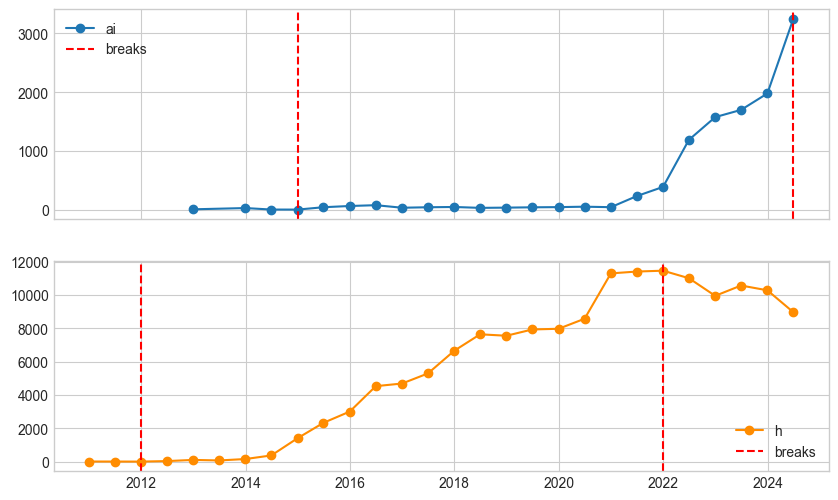

In [159]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))

nbkps = 1

y = np.array(aits.to_list())

breaks = jks.jenks_breaks(y, n_classes=nbkps)

breaks_jkp = []
for v in breaks:
    idx = aits.index[aits == v]
    breaks_jkp.append(idx)

ax1.plot(aits, marker="o", label='ai')

print_legend = True
for i in breaks_jkp:
    if print_legend:
        ax1.axvline(i, color= 'red', linestyle= 'dashed', label= 'breaks')
        print_legend= False
    else:
        ax1.axvline(i, color= 'red', linestyle= 'dashed')

ax1.legend()

y = np.array(hts.to_list())

model.fit(y)

breaks = jks.jenks_breaks(y, n_classes=nbkps)

breaks_jkp = []
for v in breaks:
    idx = hts.index[hts == v]
    breaks_jkp.append(idx)

ax2.plot(hts, marker= "o", label='h', color='darkorange')

print_legend = True
for i in breaks_jkp:
    if print_legend:
        ax2.axvline(i, color= 'red', linestyle= 'dashed', label= 'breaks')
        print_legend= False
    else:
        ax2.axvline(i, color= 'red', linestyle= 'dashed')

ax2.legend()
plt.show()

In [ ]:
# avg_likes = filtered_df.groupby(['genre', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].median().reset_index()

# # Pivot the data for easier plotting
# pivot_df = avg_likes.pivot(index='post_date', columns='genre', values='num_likes')
# # print(pivot_df.dtypes)
# # Plotting
# # ax = pivot_df.plot(xticks=pivot_df.index, ylabel='likes')
# pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
# plt.title('Average Number of Likes Over Time')
# plt.xlabel('Date')
# plt.ylabel('Average Number of Likes')
# plt.grid(True)
# plt.legend(title='Group')
# plt.tight_layout()
# plt.show()

In [37]:
# merged_df= pd.merge(filtered_df, profiles_df, left_on='owner_username', right_on='username')
merged_df = merged_dfe
ai_mdf = merged_df[merged_df["is_human_x"] == 0]
h_mdf = merged_df[merged_df["is_human_x"] == 1]

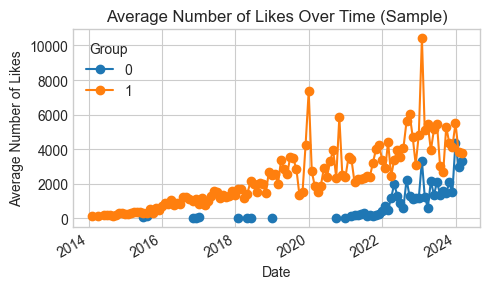

In [45]:
test = merged_df.groupby([pd.Grouper(key='post_date', freq=date_freq), 'is_human_x',pd.cut(merged_df['num_followers'], [0, 10000, 50000, 100000, 500000])], observed=False)
# print(test.apply(len))
# print("------------------------------")
temp_ngroups = 0
while(test.ngroups != temp_ngroups):
    temp_ngroups = test.ngroups
    test = test.filter(lambda x: len(x) >= 30)
    test = test.groupby([pd.Grouper(key='post_date', freq=date_freq), 'is_human_x',pd.cut(merged_df['num_followers'], [0, 10000, 50000, 100000, 500000])], observed=False)
    
# test = test.groupby([pd.Grouper(key='post_date', freq=date_freq), 'is_human_x',pd.cut(merged_df['num_followers'], [0, 10000, 50000, 100000, 500000])], observed=False)

smpl = test.sample(n=30, replace=False).reset_index()
# smpl_avg_likes = smpl.groupby(['is_human_x', pd.cut(merged_df['num_followers'], [0, 10000, 50000, 100000, 500000]), pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].mean().reset_index()
# print(test.ngroups)
smpl_avg_likes = smpl.groupby([pd.Grouper(key='post_date', freq=date_freq), 'is_human_x'])['ER'].mean().reset_index()
# smpl.groupby([pd.Grouper(key='post_date', freq=date_freq), 'is_human_x']).ngroups
pivot_df = smpl_avg_likes.pivot(index='post_date', columns='is_human_x', values='ER')

# Plotting
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time (Sample)')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

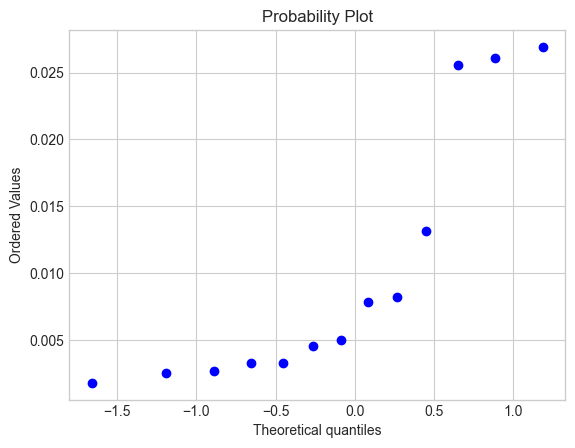

In [123]:
import scipy.stats as stats
import pylab

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
# stats.probplot(avg_likes[avg_likes["is_human"] == 0]['num_likes'], dist="norm", plot=pylab)
stats.probplot(pivot_df[1], dist="norm", plot=pylab)
pylab.show()

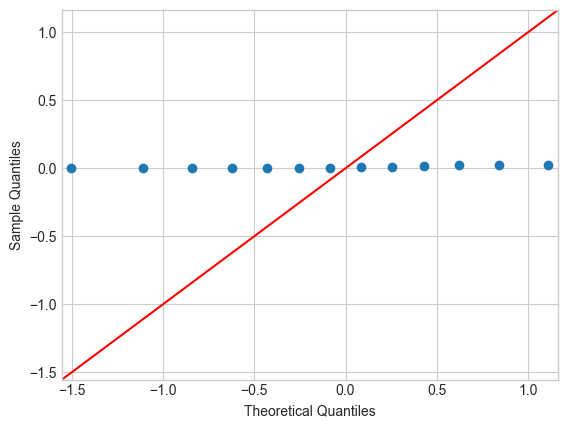

In [125]:
# %pip install statsmodels
import numpy as np
import statsmodels.api as sm
import pylab

# test = np.random.normal(0,0.5, 1000)

sm.qqplot(pivot_df[1], line='45')
pylab.show()

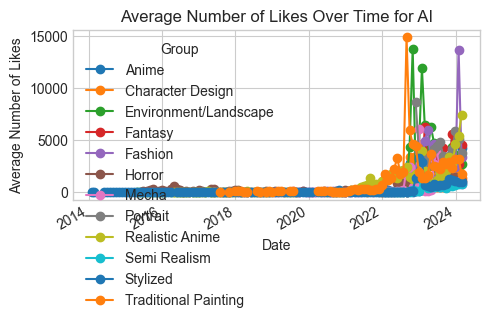

In [48]:
ai_avg_likes = ai_mdf.groupby(['genre', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].mean().reset_index()

ai_pivot_df = ai_avg_likes.pivot(index='post_date', columns='genre', values='num_likes')

ai_pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time for AI')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

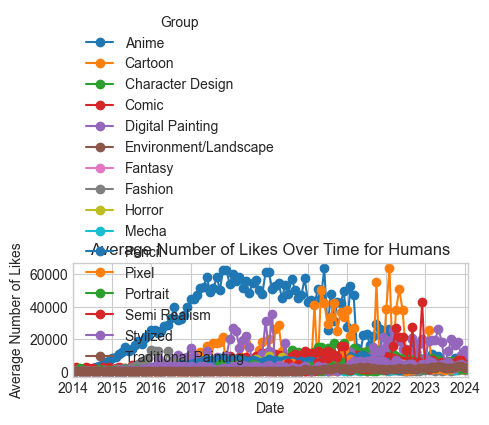

In [49]:
h_avg_likes = h_mdf.groupby(['genre', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].median().reset_index()

h_pivot_df = h_avg_likes.pivot(index='post_date', columns='genre', values='num_likes')

h_pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time for Humans')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

In [46]:
genres = np.intersect1d(ai_mdf["genre"].unique(), h_mdf["genre"].unique())

Anime


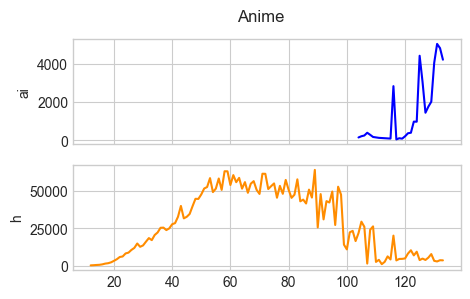

Character Design


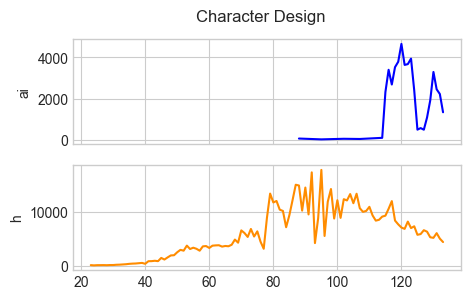

Environment/Landscape


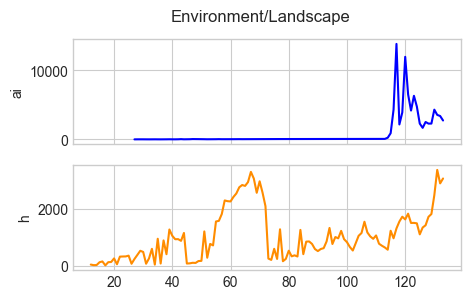

Fantasy


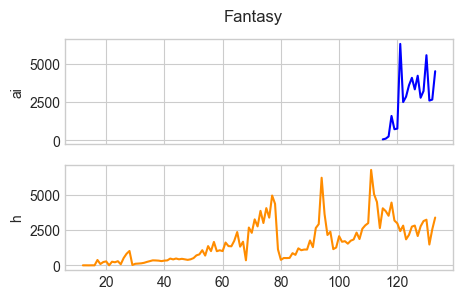

Fashion


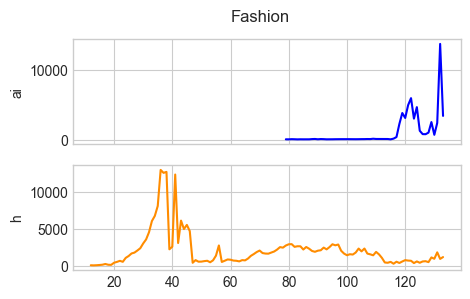

Horror


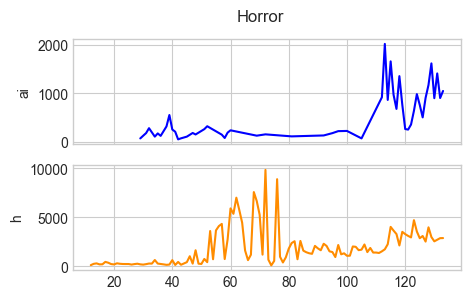

Mecha


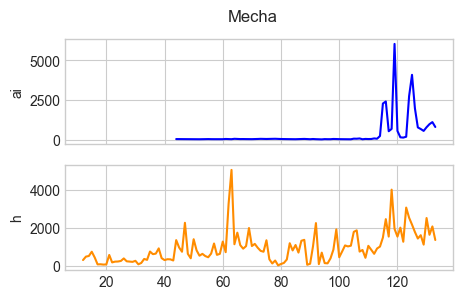

Portrait


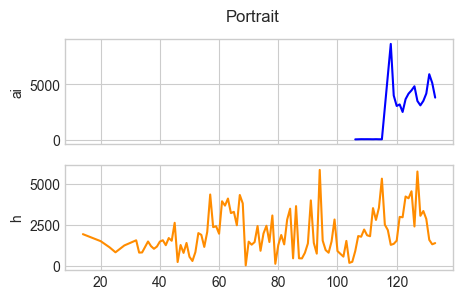

Semi Realism


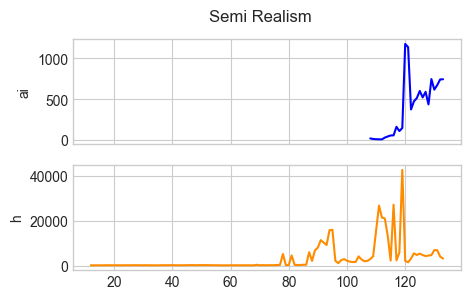

Stylized


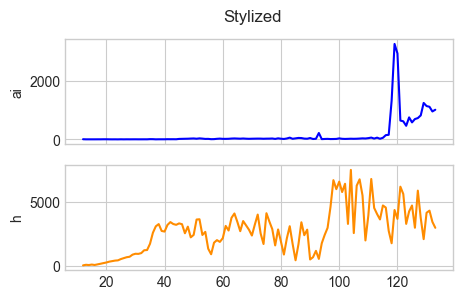

Traditional Painting


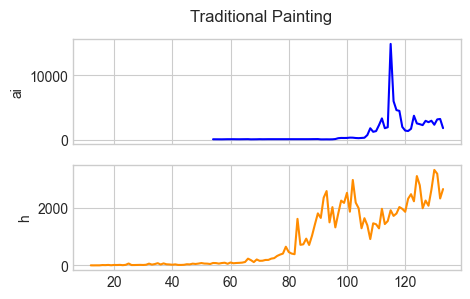

In [51]:
from operator import attrgetter
since = pd.to_datetime("2013-1-1").to_period(date_freq)
for g in genres:
    print(g)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,3))
    ai = ai_avg_likes[ai_avg_likes["genre"] == g]
    ai["post_date"] = (ai["post_date"].dt.to_period(date_freq) - since).apply(attrgetter('n'))

    ax1.plot(ai["post_date"], ai["num_likes"], color= "blue")

    h = h_avg_likes[h_avg_likes["genre"] == g]
    h["post_date"] = (h["post_date"].dt.to_period(date_freq) - since).apply(attrgetter('n'))
    # print(h)
    ax2.plot(h["post_date"], h["num_likes"], color="darkorange")
    ax1.set_ylabel("ai")
    ax2.set_ylabel("h")
    fig.suptitle(g)
    # fig.set_size(10,6)
    plt.show()

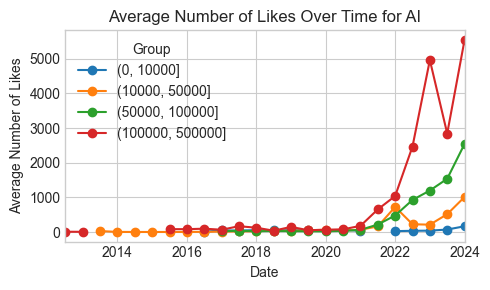

In [259]:
ai_avg_likes = ai_mdf.groupby([pd.cut(ai_mdf['num_followers'], [0, 10000, 50000, 100000, 500000]), pd.Grouper(key='post_date', freq=date_freq)], observed=False)['ER'].mean().reset_index()

pivot_df = ai_avg_likes.pivot(index='post_date', columns="num_followers", values='ER')
# print(pivot_df)
# Plotting
# ax = pivot_df.plot(xticks=pivot_df.index, ylabel='likes')
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time for AI')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

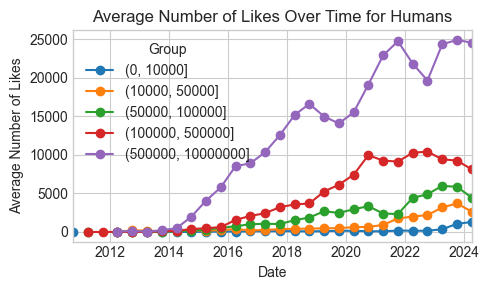

In [257]:
h_avg_likes = h_mdf.groupby([pd.cut(h_mdf['num_followers'], [0, 10000, 50000, 100000, 500000, 10000000]), 
                           pd.Grouper(key='post_date', freq=date_freq)], observed=False)['ER'].mean().reset_index()

pivot_df = h_avg_likes.pivot(index='post_date', columns="num_followers", values='ER')
# print(pivot_df)
# Plotting
# ax = pivot_df.plot(xticks=pivot_df.index, ylabel='likes')
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time for Humans')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

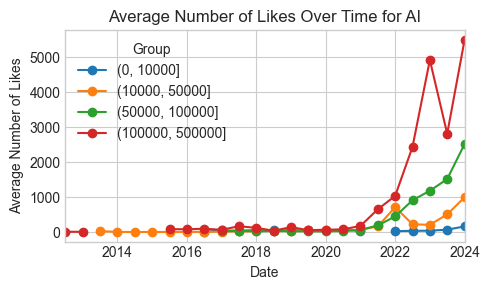

In [260]:
ai_avg_likes = ai_mdf.groupby([pd.cut(ai_mdf['num_followers'], [0, 10000, 50000, 100000, 500000]), pd.Grouper(key='post_date', freq=date_freq)], observed=False)['num_likes'].mean().reset_index()

pivot_df = ai_avg_likes.pivot(index='post_date', columns="num_followers", values='num_likes')
# print(pivot_df)
# Plotting
# ax = pivot_df.plot(xticks=pivot_df.index, ylabel='likes')
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time for AI')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

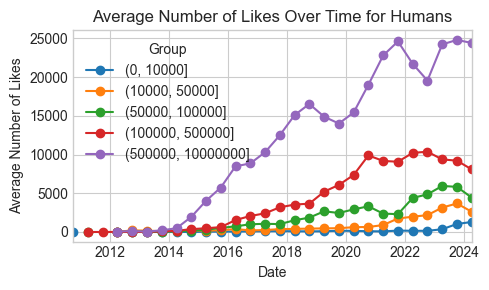

In [261]:
h_avg_likes = h_mdf.groupby([pd.cut(h_mdf['num_followers'], [0, 10000, 50000, 100000, 500000, 10000000]), 
                           pd.Grouper(key='post_date', freq=date_freq)], observed=False)['num_likes'].mean().reset_index()

pivot_df = h_avg_likes.pivot(index='post_date', columns="num_followers", values='num_likes')
# print(pivot_df)
# Plotting
# ax = pivot_df.plot(xticks=pivot_df.index, ylabel='likes')
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time for Humans')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

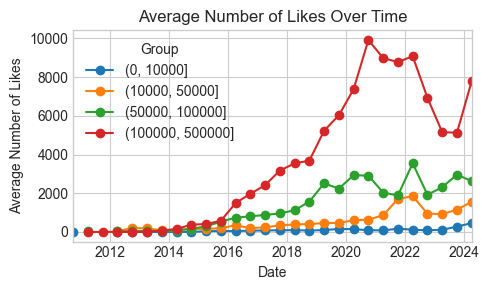

In [263]:
# merged_df= pd.merge(filtered_df, profiles_df, left_on='owner_username', right_on='username')
# merged_df
g_avg_likes = merged_df.groupby([pd.cut(merged_df['num_followers'], [0, 10000, 50000, 100000, 500000]), pd.Grouper(key='post_date', freq=date_freq)], observed=False)['ER'].mean().reset_index()

pivot_df = g_avg_likes.pivot(index='post_date', columns="num_followers", values='ER')
# print(pivot_df)
# Plotting
# ax = pivot_df.plot(xticks=pivot_df.index, ylabel='likes')
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

count    4.438900e+04
mean     1.066885e+04
std      2.709345e+04
min      1.000000e+00
25%      1.014000e+03
50%      3.177000e+03
75%      9.381000e+03
max      1.077585e+06
Name: num_likes, dtype: float64

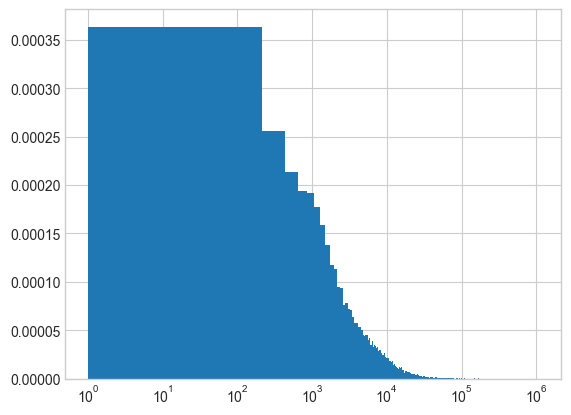

In [287]:
plt.hist((filtered_df[(filtered_df["is_human"] == 1)]["num_likes"]), density=True, bins=5000)
plt.gca().set_xscale("log")
(filtered_df[(filtered_df["is_human"] == 1)]["num_likes"]).describe()

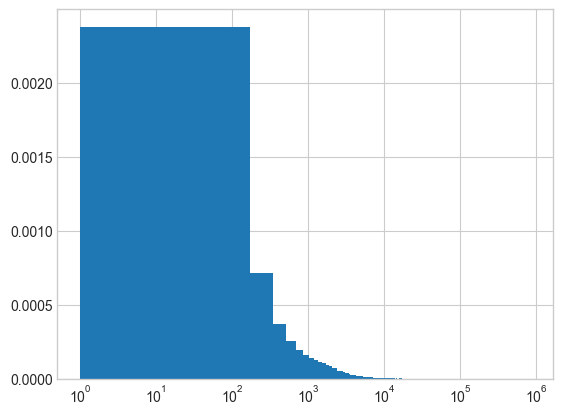

In [288]:
plt.hist((filtered_df[(filtered_df["is_human"] == 0)]["num_likes"]), density=True, bins=5000)
plt.gca().set_xscale("log")

In [298]:
avg_likes

,is_human,post_date,num_likes
0,0,2021-01-31,82.966667
1,0,2021-04-30,162.223214
2,0,2021-07-31,321.838565
3,0,2021-10-31,315.654762
4,0,2022-01-31,573.893443
5,0,2022-04-30,1152.633152
6,0,2022-07-31,855.602965
7,0,2022-10-31,1588.236834
8,0,2023-01-31,1990.852909
9,0,2023-04-30,1740.314615


In [266]:
# aia = avg_likes[avg_likes["is_human"] == 0]
# haa = avg_likes[avg_likes["is_human"] == 1]
aia = merged_dfe[merged_dfe["is_human_x"] == 0]
haa = merged_dfe[merged_dfe["is_human_x"] == 1]
aia.describe()
haa.describe()

,owner_user_id,num_likes,num_comments,post_date,is_reel,is_human_x,user_id,num_followers,num_posts,is_human_y,ER
count,5.904900e+04,5.904900e+04,59049.000000,59049,59049.0,59049.0,5.904900e+04,5.904900e+04,59049.000000,59049.0,5.904900e+04
mean,6.633607e+09,1.047095e+04,57.830971,2022-01-12 05:40:23.641433600,0.0,1.0,6.591292e+09,3.887584e+05,1988.465292,1.0,1.052878e+04
min,1.262965e+06,1.000000e+00,0.000000,2020-01-01 02:19:46,0.0,1.0,1.262965e+06,1.210000e+03,19.000000,1.0,1.000000e+00
25%,1.034817e+09,8.910000e+02,8.000000,2021-01-03 23:13:06,0.0,1.0,1.034817e+09,5.921700e+04,563.000000,1.0,9.070000e+02
50%,2.187174e+09,3.112000e+03,22.000000,2021-12-17 16:14:35,0.0,1.0,2.187174e+09,1.946420e+05,1006.000000,1.0,3.146000e+03
75%,5.887290e+09,9.675000e+03,55.000000,2023-01-29 01:24:43,0.0,1.0,5.784289e+09,5.154120e+05,3192.000000,1.0,9.728000e+03
max,6.092085e+10,1.077585e+06,21131.000000,2024-02-27 22:37:11,0.0,1.0,6.017246e+10,8.687125e+06,7907.000000,1.0,1.079393e+06
std,1.207954e+10,2.591174e+04,218.828039,NaN,0.0,0.0,1.200828e+10,7.254656e+05,2162.308526,0.0,2.601008e+04


In [ ]:
# aia.drop('post_date', axis= 1)
# aia.drop('post_date', axis= 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


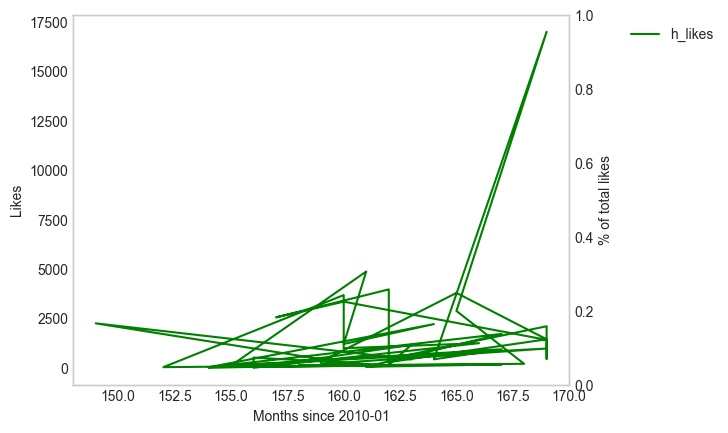

In [274]:
import operator
since = pd.to_datetime("2010-1-1").to_period(date_freq)
merged_df = pd.merge(aia, haa, on='post_date', suffixes=('_ai', '_h'))
# merged_df
# sum_likes.drop(["is_human_ai"], axis=1)
merged_df['sum_likes'] = merged_df['num_likes_ai'] + merged_df['num_likes_h']
fig, ax = plt.subplots()

merged_df["post_date"] = (merged_df["post_date"].dt.to_period(date_freq) - since).apply(operator.attrgetter('n'))


# print(merged_df["post_date"])
ax2 = ax.twinx()
ax.plot(merged_df["post_date"], merged_df["ER_ai"], color='green', label= "h_likes")
# ax.plot(merged_df["post_date"], merged_df["num_likes_ai"], color='orange', label= "ai_likes")
# ax.plot(merged_df["post_date"], merged_df["sum_likes"], color='black', label= "sum_likes")

# ax2.plot(merged_df["post_date"], (merged_df["num_likes_h"] / merged_df["sum_likes"]), color='red', label= "hp")
# ax2.plot(merged_df["post_date"], (merged_df["num_likes_ai"] / merged_df["sum_likes"]), color='blue', label= "aip")
ax.set_xlabel("Months since " + str(since))
ax.set_ylabel("Likes")
ax2.set_ylabel("% of total likes")#, rotation= 270)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.8))
ax.grid()
ax2.grid()
plt.show()

In [275]:
# fig, ax = plt.subplots()
# ax.plot(merged_df["num_likes_ai"], merged_df["num_likes_h"], color='black', label= "ai vs h")
# ax.plot(merged_df["num_likes_h"], merged_df["num_likes_ai"], color='black', label= "ai vs h", type= "scatter")
merged_df.head()
# merged_df.plot.scatter(x="num_likes_ai", y="num_likes_h")
# plt.show()
# merged_df["num_likes_h"].corr(merged_df["num_likes_ai"])

,shortcode_ai,owner_user_id_ai,owner_username_ai,num_likes_ai,num_comments_ai,post_date,is_reel_ai,is_human_x_ai,user_id_ai,username_ai,...,is_reel_h,is_human_x_h,user_id_h,username_h,num_followers_h,num_posts_h,is_human_y_h,genre_h,ER_h,sum_likes
0,CqbIxKnoQ31,49210030405,anime00s,134,4,158,0,0,49210030405,anime00s,...,0,1,43403349840,rxzarx,30642,163,1,Digital Painting,692,820
1,C1BJeXvLaIR,59844763990,ai_hiro_abe,170,5,167,0,0,59844763990,ai_hiro_abe,...,0,1,415574572,cordeliacarla,155344,385,1,Environment/Landscape,2969,3116
2,CtFTyFcoOh9,34506649916,kaptaincoca,58,1,161,0,0,34506649916,kaptaincoca,...,0,1,1543039379,thealexrossart,795914,7907,1,Comic,4712,4767
3,C0xqBQJroT0,60155307364,prompt.soru,1691,28,167,0,0,60155307364,prompt.soru,...,0,1,1591984508,koyori_n,632600,3214,1,Character Design,4492,6176
4,Ckxg3gnIrBl,56495916045,wh3re.is.the.sun,28,2,154,0,0,56495916045,wh3re.is.the.sun,...,0,1,21467530,paulkenton,515412,6264,1,Environment/Landscape,931,951
